# Grupo A3 - Classification using feature vectors

 In this project we will extract features from the shapes present in the images in order to correctly classify the EMNIST dataset. 
 
The features to be extracted are:

- area of shape
- eccentricity
- equivalent diameter
- euler number
- extent
- centroid
- mean intensity (of the gray-level image)
- major-axis length
- minor-axis length
- ratio between major-axis length  and minor-axis length
- orientation
- perimeter
- solidity
- perimeter-to-area ratio
- standard deviation (of the gray-level image)

The classifiers that will be used are: 

- SVM with linear kernel
- gradient Boosting

We will use the classifiers from scikit-learn

#  Loading Data

## Imports

In [2]:
import sys
sys.path.append('../../')

from sarpy.datasets import load_emnist
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
from skimage.morphology import disk, binary_dilation
from skimage.measure import label, regionprops

## Loading data set and binarizing the images

In [3]:
X_train, y_train, X_test, y_test, X_valid, y_valid, mapping, nb_classes = load_emnist('balanced', validation=True)
X_train = np.squeeze(X_train)
X_valid = np.squeeze(X_valid)
X_test = np.squeeze(X_test)
y_train = np.ravel(y_train)
y_valid = np.ravel(y_valid)
y_test  = np.ravel(y_test)
print(np.shape(X_train), np.shape(y_train))

reshape testing: 100%|██████████| 18800/18800 [00:00<00:00, 92882.44it/s]


Train size: 94000
Test size: 18800
Validation size: 18800
# classes: 47
(94000, 28, 28) (94000,)


### Reducing Training dataset

In [4]:
def reduce(data, labels, n_samples, n_class, mapping):
    images_class = []
    for class_ in mapping:
        images_class += [np.where(labels == class_)[0]]

    data_red = []
    label_red = []
    for class_ in images_class:
        index_class = np.random.choice(class_, n_samples, replace=False)
        data_red += [data[index_class]]
        label_red += [labels[class_[0]]]*n_samples
#         plt.imshow(np.squeeze(data[class_[0]]), cmap = 'gray')
#         plt.show()
    data_red = np.array(data_red).reshape((n_samples*n_class, 28, 28))
    label_red = np.array(label_red)
    return data_red, label_red

In [5]:
n_trains = [300, 500, 700, 900]
n_valids = [100, 200, 300, 400]
n_tests = [100, 200, 300, 400]
X_train_red = []
y_train_red = []
X_valid_red = []
y_valid_red = []
X_test_red = []
y_test_red = []
for i in range(len(n_trains)):
    xt, yt = reduce(X_train, y_train, n_trains[i], nb_classes, mapping)
    X_train_red += [xt]
    y_train_red += [yt]
    xte, yte = reduce(X_test, y_test, n_tests[i], nb_classes, mapping)
    X_test_red += [xte]
    y_test_red += [yte]
    xv, yv = reduce(X_valid, y_valid, n_valids[i], nb_classes, mapping)
    X_valid_red += [xv]
    y_valid_red += [yv]
print(len(X_train_red), len(X_test_red), len(X_valid_red))

4 4 4


### Extracting foreground with a priori threshold

In [6]:
def bin_image(imset, thresh = 40):
    imsetb = imset > thresh
    imsetb = imsetb.astype(int)
    return imsetb
X_trainb = []
X_testb = []
X_validb = []
for i in range(len(n_trains)):
    X_trainb += [[bin_image(x_t, 50) for x_t in X_train_red[i]]]
    X_validb += [[bin_image(x_v, 50) for x_v in X_valid_red[i]]]
    X_testb += [[bin_image(x_te, 50) for x_te in X_test_red[i]]]
print(len(X_trainb), len(X_testb), len(X_validb))

4 4 4


In [ ]:
for i in range(47):
    plt.subplot(1, 6, 1)
    plt.imshow(X_train_red[0][i*n_trains[0]], cmap='gray')
    plt.title("Train")
    plt.subplot(1, 6, 2)
    plt.imshow(X_trainb[0][i*n_trains[0]], cmap='gray')
    plt.subplot(1, 6, 3)
    plt.imshow(X_valid_red[0][i*n_valids[0]], cmap='gray')
    plt.title("Validation")
    plt.subplot(1, 6, 4)
    plt.imshow(X_validb[0][i*n_valids[0]], cmap='gray')
    plt.subplot(1, 6, 5)
    plt.imshow(X_test_red[0][i*n_tests[0]], cmap='gray')
    plt.title("Test")
    plt.subplot(1, 6, 6)
    plt.imshow(X_testb[0][i*n_tests[0]], cmap='gray')
    print(y_train_red[0][i*300])
    plt.show()

### Extracting foreground  with Otsu

In [7]:
def bin_otsu(images):
    new_images = []
    for image in images:
        t  = filters.threshold_otsu(image)
        new_images += [(image>t).astype(int)]
    return np.array(new_images)

In [8]:
X_train_otsu = [bin_otsu(xt) for xt in X_train_red]
X_valid_otsu = [bin_otsu(xv) for xv in X_valid_red]
X_test_otsu = [bin_otsu(xte) for xte in X_test_red]
print(len(X_train_otsu), len(X_valid_otsu), len(X_test_otsu), np.shape(X_train_otsu[0]))

4 4 4 (14100, 28, 28)


In [ ]:
for i in range(47):
    plt.subplot(1, 3, 1)
    plt.imshow(X_train_red[0][i*n_trains[0]], cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(X_trainb[0][i*n_trains[0]], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(X_train_otsu[0][i*n_trains[0]], cmap='gray')
    plt.show()

## Performing morphologic transforms to correct connectivity

In [9]:
def connect(imgs):
    disk3 = disk(2)
    new_imgs = []
    coefs = []
    for img, i in zip(imgs, range(len(imgs))):
        while np.max(label(img)) > 2:
            img = binary_dilation(img, disk3)
            coefs+= [i]
        new_imgs += [img]
    return new_imgs, np.unique(coefs)

In [10]:
def hist_components(imgs, text):
    new_imgs = [label(img) for img in imgs]
    comps = [np.max(new_img) for new_img in new_imgs]
    plt.hist(comps)
    plt.title(text)
    plt.show()

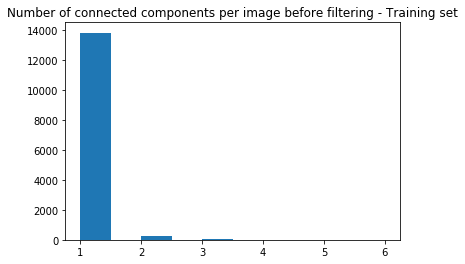

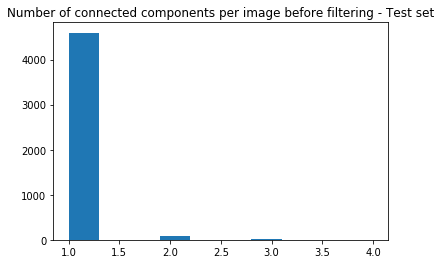

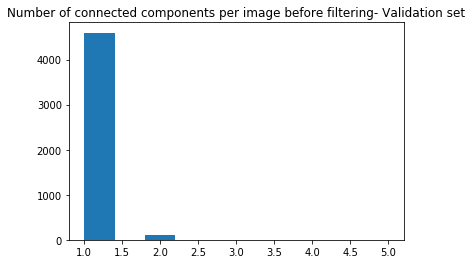

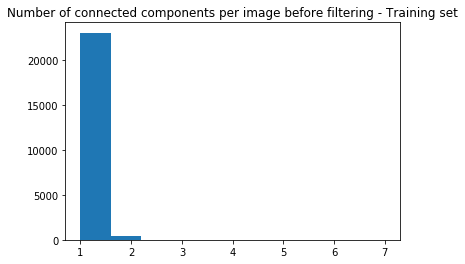

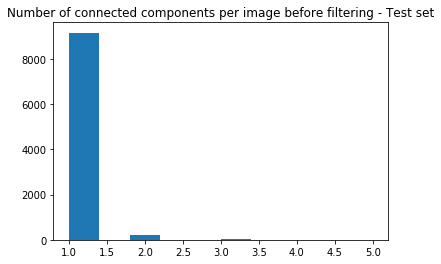

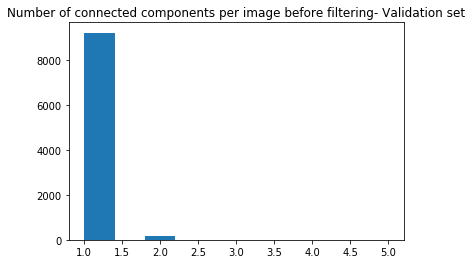

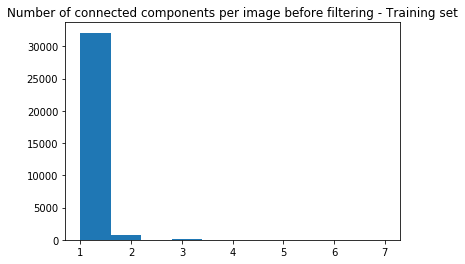

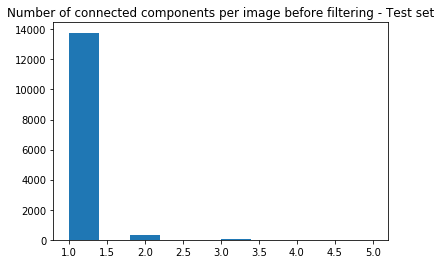

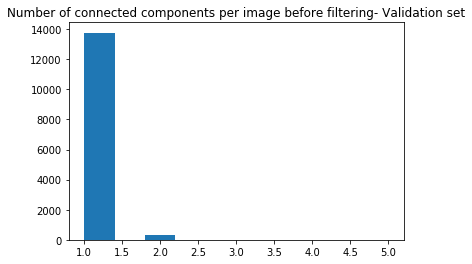

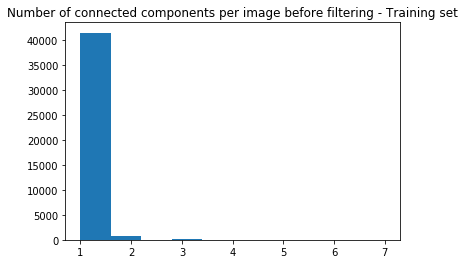

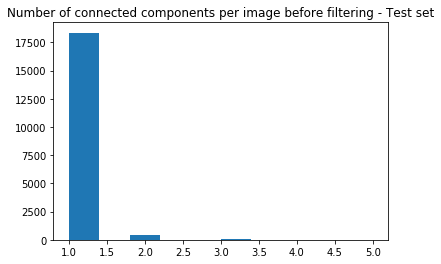

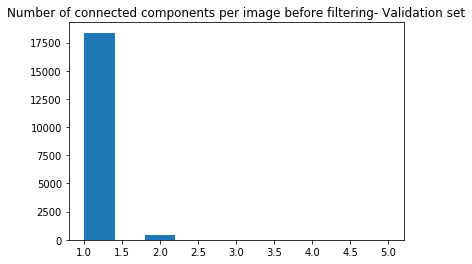

In [11]:
for i in range(len(n_trains)):
    hist_components(X_train_otsu[i], "Number of connected components per image before filtering - Training set")
    hist_components(X_test_otsu[i], "Number of connected components per image before filtering - Test set")
    hist_components(X_valid_otsu[i], "Number of connected components per image before filtering- Validation set")

In [12]:
def remove_noise(imgs, thresh):
    new_imgs = []
    coefs = []
    for img, i in zip(imgs, range(len(imgs))):
        imgl = label(img)
        new_img = np.copy(img)
        if np.max(imgl) > 1:
            props = regionprops(imgl)
            areas = [props[i].area for i in range(np.max(imgl))]
            for area, j in zip(areas, range(len(areas))):
                if area < thresh:
                    coefs +=[i]
                    a, b, c, d = props[j].bbox
                    new_img[a:c, b:d] = 0
        new_imgs += [new_img] 
    return new_imgs, coefs
        

In [13]:
X_train_otsu_clean = []
X_valid_otsu_clean = []
X_test_otsu_clean = []
coefstrain = []
coefsvalid = []
coefstest = []
for i in range(len(X_train_otsu)):
    xt, coefs = remove_noise(X_train_otsu[i], 10)
    X_train_otsu_clean += [xt]
    coefstrain += [coefs]
    xte, coefst = remove_noise(X_test_otsu[i], 10)
    X_test_otsu_clean += [xte]
    coefstest += [coefst]
    xv, coefsv = remove_noise(X_valid_otsu[i], 10)
    X_valid_otsu_clean += [xv]
    coefsvalid += [coefsv]

In [ ]:
print(len(X_train_otsu_clean), len(X_valid_otsu_clean), len(X_test_otsu_clean), np.shape(X_train_otsu_clean[0]))

In [ ]:
for i in coefstrain[0]:
    plt.subplot(1, 2, 1)
    plt.imshow(X_train_otsu[0][i], cmap = 'gray')
    plt.title("Train - Original")
    plt.subplot(1, 2, 2)
    plt.imshow(X_train_otsu_clean[0][i], cmap = 'gray')
    plt.title("Train - Filtered")
    plt.show()

In [ ]:
for i in coefstest[2]:
    plt.subplot(1, 2, 1)
    plt.imshow(X_test_otsu[2][i], cmap = 'gray')
    plt.title("Test - Original")
    plt.subplot(1, 2, 2)
    plt.imshow(X_test_otsu_clean[2][i], cmap = 'gray')
    plt.title("Test - Filtered")
    plt.show()

In [ ]:
for i in range(len(X_train_otsu)):
    hist_components(X_train_otsu_clean[i], "Number of connected components per image after filtering- Training set")
    hist_components(X_test_otsu_clean[i], "Number of connected components per image after filtering - Test set")
    hist_components(X_valid_otsu_clean[i], "Number of connected components per image after filtering - Validation set")

# Extracting Features

## Imports

In [14]:
from skimage.measure import regionprops, label
from scipy import ndimage

## Feature extraction

The features extracted from the shape are, as previously cited:
- area :the number of pixels belonging to the shape.
- eccentricity: refers to the ratio $\frac{FocalDistance}{||MajorAxis||}$ of  the ellipse with same variance as the shape.
- equivalent diameter: diameter of the circle which has the same area as the shape.
- euler number: topological measure. $Euler_{number} = n_c - n_h$, where $n_c$ is the number of connected components on the image and $n_h$ is the number of holes.
- extent (or rectangularity):  $\frac{area}{area(MER)}$; ratio between the shape's area and the minimum-enclosing-rectangle that contains the shape.
- centroid: center of mass of the shape. $(S_{x0}, S_{y0}) = (\frac{\sum{S_{xi}}}{N}, \frac{\sum{S_{yi}}}{N}) $.
- mean intensity: refers to the mean value of the intensities of the gray-level image of the shape.
- major-axis length: 
- minor-axis length:
- orientation: refers to the angle between the shape's major axis and the horizontal axis (x).
- perimeter: the number of pixels in the shape's contour (extracted considering 8-conneted neighborhood)
- solidity: $\frac{area}{ConvexHullArea}$
- standand deviation: refers to the standard deviation value of the intensities of the gray-level image of the shape.

In [15]:
def feature_extraction_2(image_bin, image_gray):
    features = []
    img_binl = label(image_bin)
    props = regionprops(label_image=img_binl, intensity_image=image_gray)
    max_comp = 0
    if np.max(img_binl) > 1:
        areas = [props[i].area for i in range(np.max(img_binl))]
        max_comp = np.argmax(areas)
    
    features.append(props[max_comp].area)
    features.append(props[max_comp].eccentricity)
    features.append(props[max_comp].equivalent_diameter)
    features.append(props[max_comp].euler_number)
    features.append(props[max_comp].extent)
    lcx, lcy = props[max_comp].centroid
    features.append(lcx)
    features.append(lcy)
    features.append(props[max_comp].mean_intensity)
    features.append(props[max_comp].major_axis_length)
    features.append(props[max_comp].minor_axis_length)
    features.append(props[max_comp].major_axis_length/props[max_comp].minor_axis_length)
    features.append(props[max_comp].orientation)
    features.append(props[max_comp].perimeter)
    features.append(props[max_comp].solidity)
    features.append(props[max_comp].perimeter/props[max_comp].area)
    features.append(ndimage.standard_deviation(image_gray))
    return features

In [16]:
f_trains = []
f_valids = []
f_tests = []
for i in range(len(X_train_otsu_clean)):
    f_trains += [[feature_extraction_2(imageb, np.squeeze(imageg)) for imageb, imageg in zip(X_train_otsu_clean[i], X_train_red[i])]]
    print("Created train feature vector")

    f_tests += [[feature_extraction_2(imageb, np.squeeze(imageg)) for imageb, imageg in  zip(X_test_otsu_clean[i], X_test_red[i])]]
    print("Created test feature vector")


    f_valids += [[feature_extraction_2(imageb, np.squeeze(imageg)) for imageb, imageg in zip(X_valid_otsu_clean[i], X_valid_red[i])]]
    print("Created valid feature vector")
print(len(f_trains), len(f_valids), len(f_tests), len(f_trains[0]))

Created train feature vector
Created test feature vector
Created valid feature vector
Created train feature vector
Created test feature vector
Created valid feature vector
Created train feature vector
Created test feature vector
Created valid feature vector
Created train feature vector
Created test feature vector
Created valid feature vector
4 4 4 14100


### Separating Digits from Letters

In [17]:
def sep_dig(data, labels, n_samples):
    data_dig = data[:10*n_samples]
    labels_dig = labels[:10*n_samples]
    data_let = data[10*n_samples:]
    labels_let  = labels[10*n_samples:]
    return data_dig, labels_dig, data_let, labels_let

In [35]:
f_trains_dig, y_trains_dig, f_trains_let, y_trains_let  = [] , [], [], []
f_valids_dig, y_valids_dig, f_valids_let, y_valids_let  = [] , [], [], []
f_tests_dig, y_tests_dig, f_tests_let, y_tests_let  = [] , [], [], []

for i in range(len(f_trains)):
    f_train_dig, y_train_dig, f_train_let, y_train_let = sep_dig(f_trains[i], y_train_red[i], n_trains[i])
    f_trains_dig += [f_train_dig] 
    y_trains_dig += [y_train_dig]
    f_trains_let += [f_train_let]
    y_trains_let += [y_train_let]
    f_test_dig, y_test_dig, f_test_let, y_test_let = sep_dig(f_tests[i], y_test_red[i], n_tests[i]) 
    f_tests_dig += [f_test_dig] 
    y_tests_dig += [y_test_dig]
    f_tests_let += [f_test_let]
    y_tests_let += [y_test_let]
    f_valid_dig, y_valid_dig, f_valid_let, y_valid_let = sep_dig(f_valids[i], y_valid_red[i], n_valids[i])
    f_valids_dig += [f_valid_dig] 
    y_valids_dig += [y_valid_dig]
    f_valids_let += [f_valid_let]
    y_valids_let += [y_valid_let]
    
print(y_tests_dig[0].shape)

(1000,)


### Shuffling the feature vector

In [59]:
#TODO: fix it
def permute(data, labels, n_samples, nb_classes):
    perm = np.random.permutation(np.arange(n_samples*nb_classes))
    print(perm[0])
    new_data = np.array(data, copy = True)[perm]
    new_labels = np.array(labels, copy = True)[perm]
    return new_data, new_labels

In [54]:
f_train_perm, y_train_perm, f_test_perm, y_test_perm, f_valid_perm, y_valid_perm = [], [], [], [], [], []
for i in range(len(n_trains)):
    tp, ytp = permute(f_trains[i], y_train_red[i], n_trains[i], nb_classes)
    f_train_perm += [tp]
    y_train_perm += [ytp]
    tep, ytep = permute(f_tests[i], y_test_red[i], n_tests[i], nb_classes)
    f_test_perm += [tep]
    y_test_perm += [ytep]
    vp, yvp = permute(f_valids[i], y_valid_red[i], n_valids[i], nb_classes)
    f_valid_perm += [vp]
    y_valid_perm += [yvp]
    

7722
2010
2307
19880
833
8729
21913
9873
8982
26509
4341
7640


In [56]:
print(y_test_perm[0][2010])
plt.imshow()


43


# Fitting Classifiers

## Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
import time

## Feature Selection and normalization


In [22]:
def feature_sel(train, test, valid):
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    train_sel = sel.fit_transform(train)
    test_sel = sel.fit_transform(test)
    valid_sel = sel.fit_transform(valid)
    print(train_sel.shape, test_sel.shape, valid_sel.shape)
    return train_sel, test_sel, valid_sel

def normalize(train, test, valid):
    stdScaler = StandardScaler()
    train_norm = stdScaler.fit_transform(train)
    test_norm = stdScaler.fit_transform(test)
    valid_norm = stdScaler.fit_transform(valid)
    return train_norm, test_norm, valid_norm

def transform(trains, tests, valids):
    train_norm, test_norm, valid_norm = [], [], []
    for i in range(len(trains)):
        train, test, valid = normalize(*feature_sel(trains[i], tests[i], valids[i]))
        train_norm += [train]
        test_norm += [test]
        valid_norm += [valid]
    print(len(train_norm), len(test_norm), len(valid_norm))
    return train_norm, test_norm, valid_norm

## Classification

In [29]:
clfs = [SVC(kernel='linear', C = 0.01), GradientBoostingClassifier()]
clfs_names = ["SVM com Kernel Linear", "Gradient Boosting"]

train_norm, test_norm, valid_norm = transform(f_train_perm, f_test_perm, f_valid_perm)
train_digs_norm, test_digs_norm, valid_digs_norm = transform(f_trains_dig, f_tests_dig, f_valids_dig)
train_lets_norm, test_lets_norm, valid_lets_norm = transform(f_trains_let, f_tests_let, f_valids_let)

def classify(trains, trains_label, tests, tests_label, valids, valids_label, clfs, clfs_names):
    score = dict()
    valid_e = dict()
    times = dict()
    classifier = dict()
    print(tests_label[0].shape)
    for cla, i in zip(clfs, clfs_names):
        if not i in score:
            score[i], valid_e[i], times[i], classifier[i] = [], [], [], []
        for j in range(len(trains)):
            clf = cla
            start = time.time()
            classifier[i] += [clf.fit(trains[j], trains_label[j])]
            end  = time.time()
            score[i] += [[clf.score(tests[k], tests_label[k]) for k in range(len(tests))]]
            valid_e[i] += [[clf.score(valids[k], valids_label[k]) for k in range(len(valids))]]
            times[i] += [end-start]
            
    return classifier, score, valid_e, times

(14100, 12) (4700, 12) (4700, 12)
(23500, 12) (9400, 12) (9400, 12)
(32900, 12) (14100, 12) (14100, 12)
(42300, 12) (18800, 12) (18800, 12)
4 4 4
(3000, 12) (1000, 12) (1000, 12)
(5000, 12) (2000, 12) (2000, 12)
(7000, 12) (3000, 12) (3000, 12)
(9000, 12) (4000, 12) (4000, 12)
4 4 4
(11100, 12) (3700, 12) (3700, 12)
(18500, 12) (7400, 12) (7400, 12)
(25900, 12) (11100, 12) (11100, 12)
(33300, 12) (14800, 12) (14800, 12)
4 4 4


In [24]:
classifiers, scores, valid_errs, times = classify(train_norm, y_train_red, test_norm, y_test_red, valid_norm, y_valid_red, clfs, clfs_names)

### Classifying only digits

In [36]:
classfiers_dig, scores_dig, valid_errs_dig, times_dig = classify(train_digs_norm, y_trains_dig, test_digs_norm, y_tests_dig, valid_digs_norm, y_valids_dig, clfs, clfs_names)

(1000,)


### Classifying only letters

In [37]:
classfiers_let, scores_let, valid_errs_let, times_let = classify(train_lets_norm, y_trains_let, test_lets_norm, y_tests_let, valid_lets_norm, y_valids_let, clfs, clfs_names)

(3700,)


# Results

## Imports

In [38]:
from sklearn import metrics
import pprint, binascii
import seaborn as sns

## Confusion Matrix, accuracy and time graphs

In [39]:
characters = [binascii.b2a_qp(mapping[i]).decode('ascii') for i in mapping]

In [40]:
def heatmap(test, label, classifier, characters, title):
        fig, ax = plt.subplots(figsize=(20,20)) 
        pred = classifier.predict(test)
        sns.heatmap(metrics.confusion_matrix(label, pred), xticklabels=characters, yticklabels=characters)
        plt.title(title)
        plt.show()

In [51]:
def acc(clf_names, scores, n_trains, n_tests, name):
    for clf_name in clfs_names:
        fig, ax = plt.subplots(figsize=(30, 10)) 
        for scr, size, i in zip(scores[clf_name], n_trains, range(len(n_trains))):
            plt.subplot(1, len(n_trains), i+1)
            plt.plot(scr)
            plt.title("Accuracy in " + name + " set" + clf_name)
            plt.xticks(np.arange(4), (n_tests))
            plt.ylabel("Accuracy - training set with " + str(size)+ "samples per class")
        plt.show()    

In [42]:
def time_graph(clfs_names, times, n_trains):
    for clf in clfs_names:
        fig, ax = plt.subplots(figsize=(10,8)) 
        plt.plot(times[clf])
        plt.xticks(np.arange(4), (n_trains))
        plt.title("Execution time for " + clf + " per training set size (s)")   
        plt.ylabel("seconds")
        plt.xlabel("Training set size")
        plt.show()

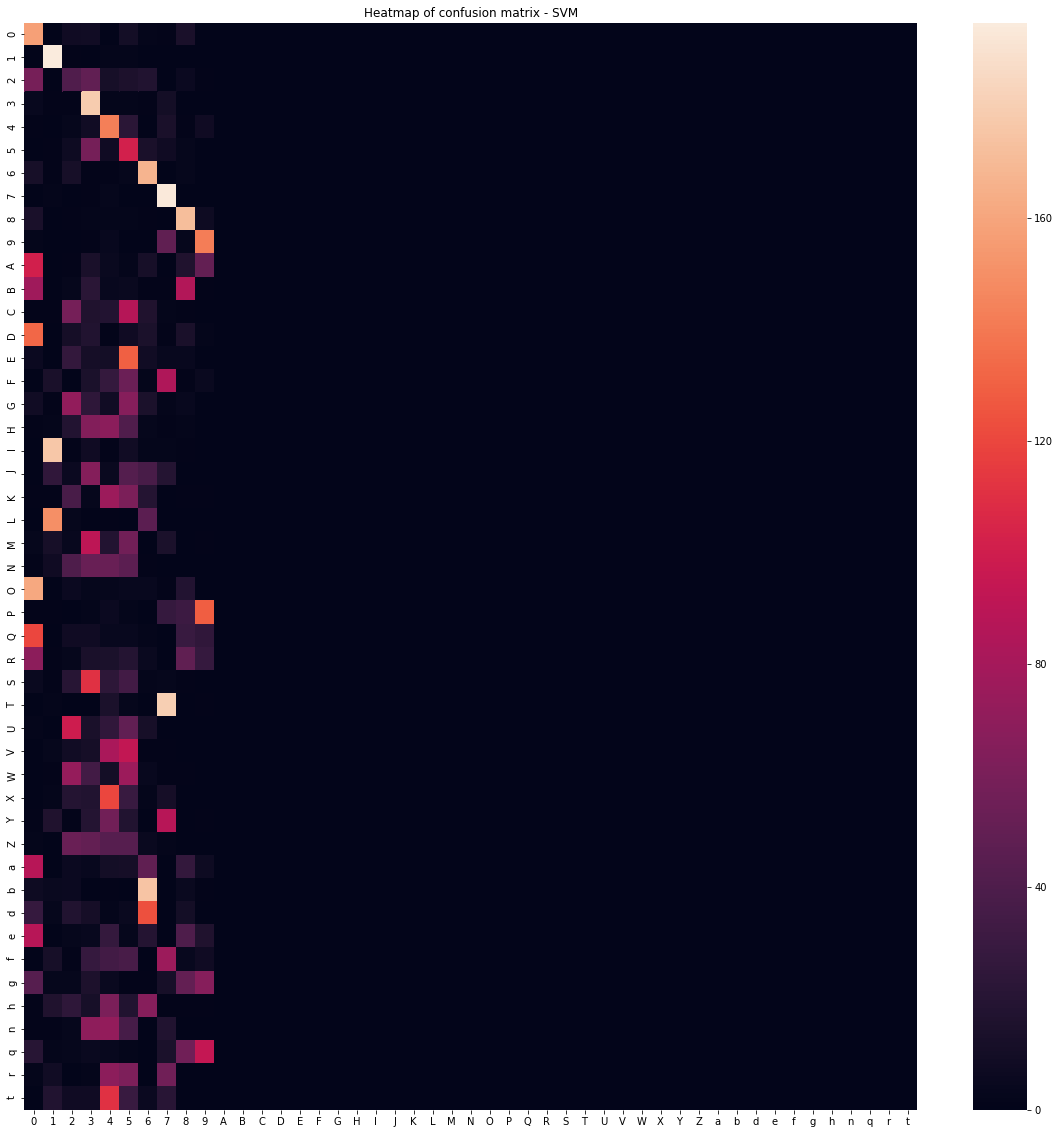

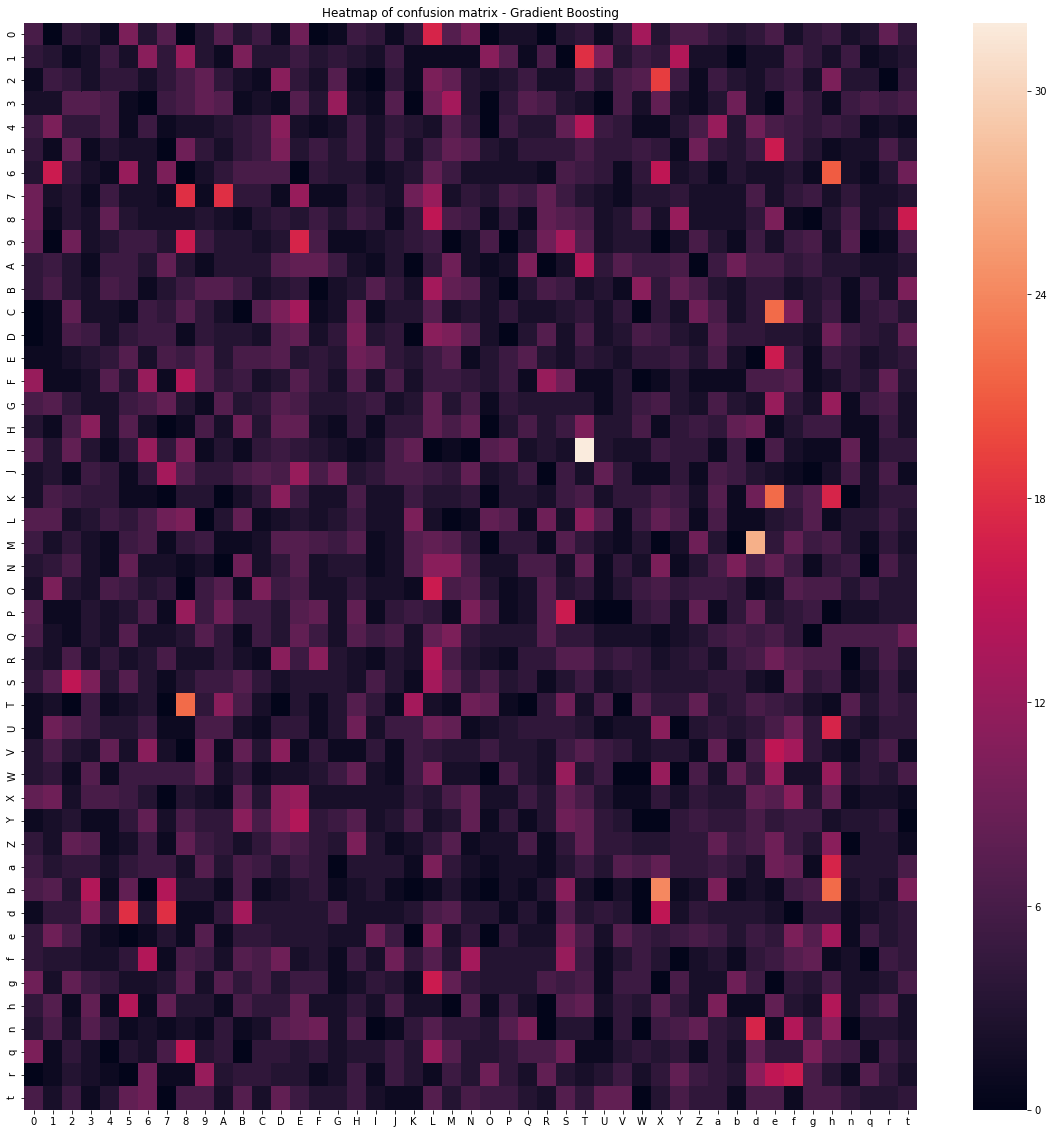

In [49]:
heatmap(test_norm[1], y_test_perm[1], classifiers[clfs_names[0]][0], characters, title='Heatmap of confusion matrix - SVM')
heatmap(test_norm[1], y_test_perm[1], classifiers[clfs_names[1]][0], characters, title='Heatmap of confusion matrix - Gradient Boosting')

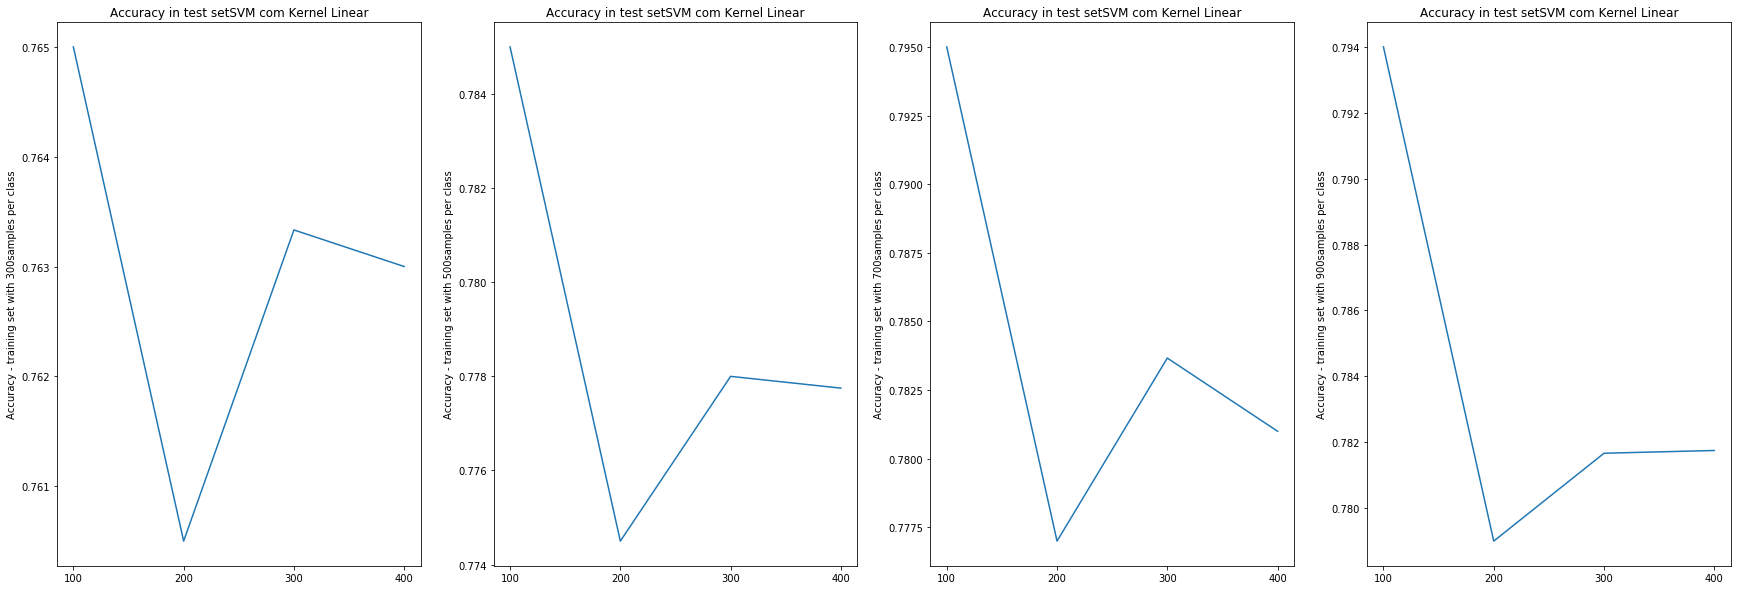

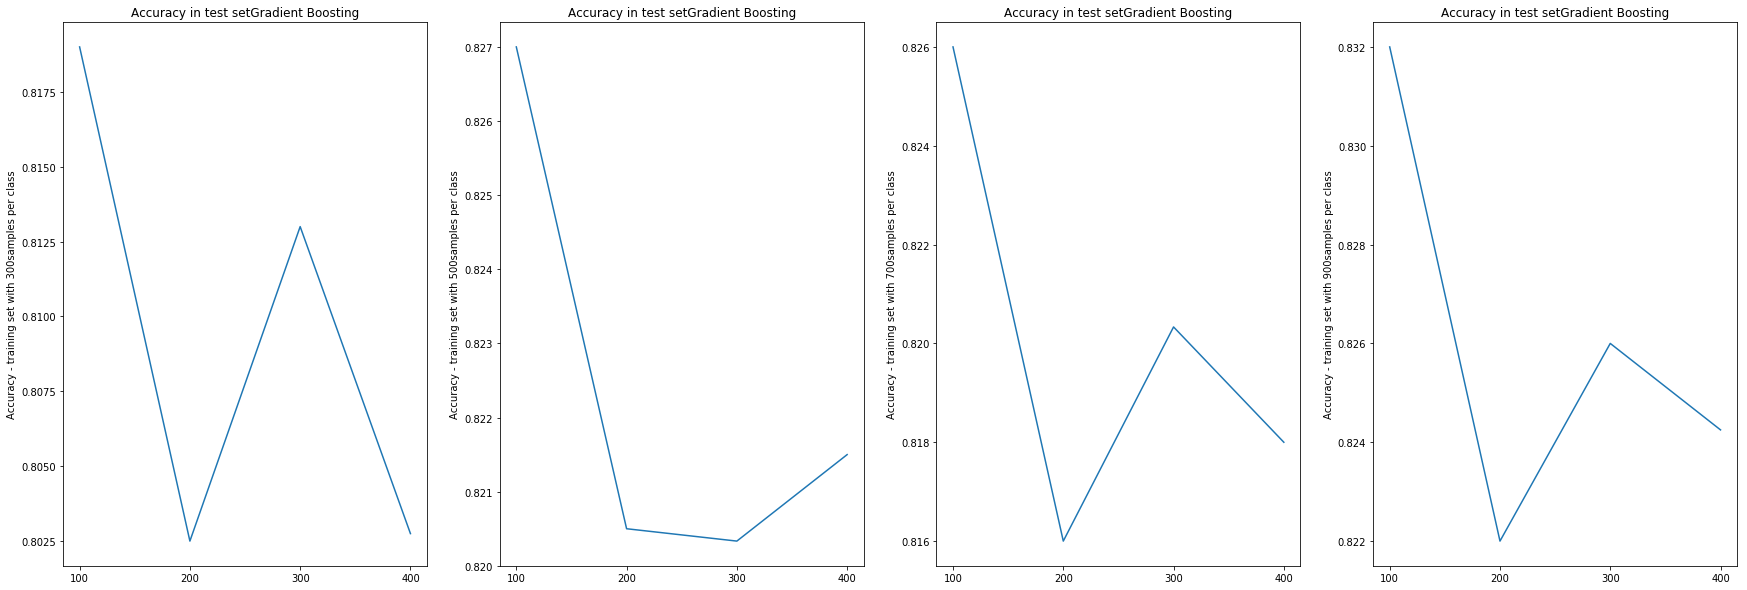

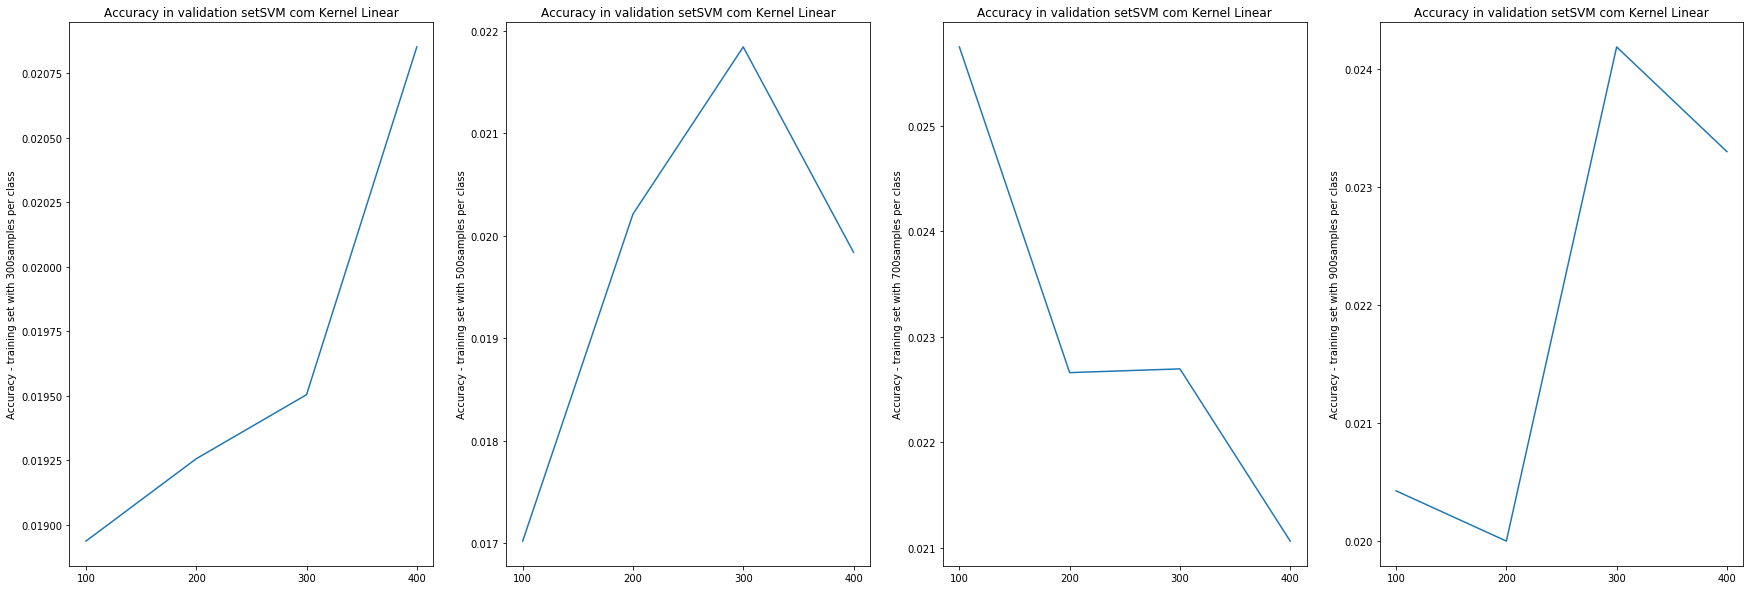

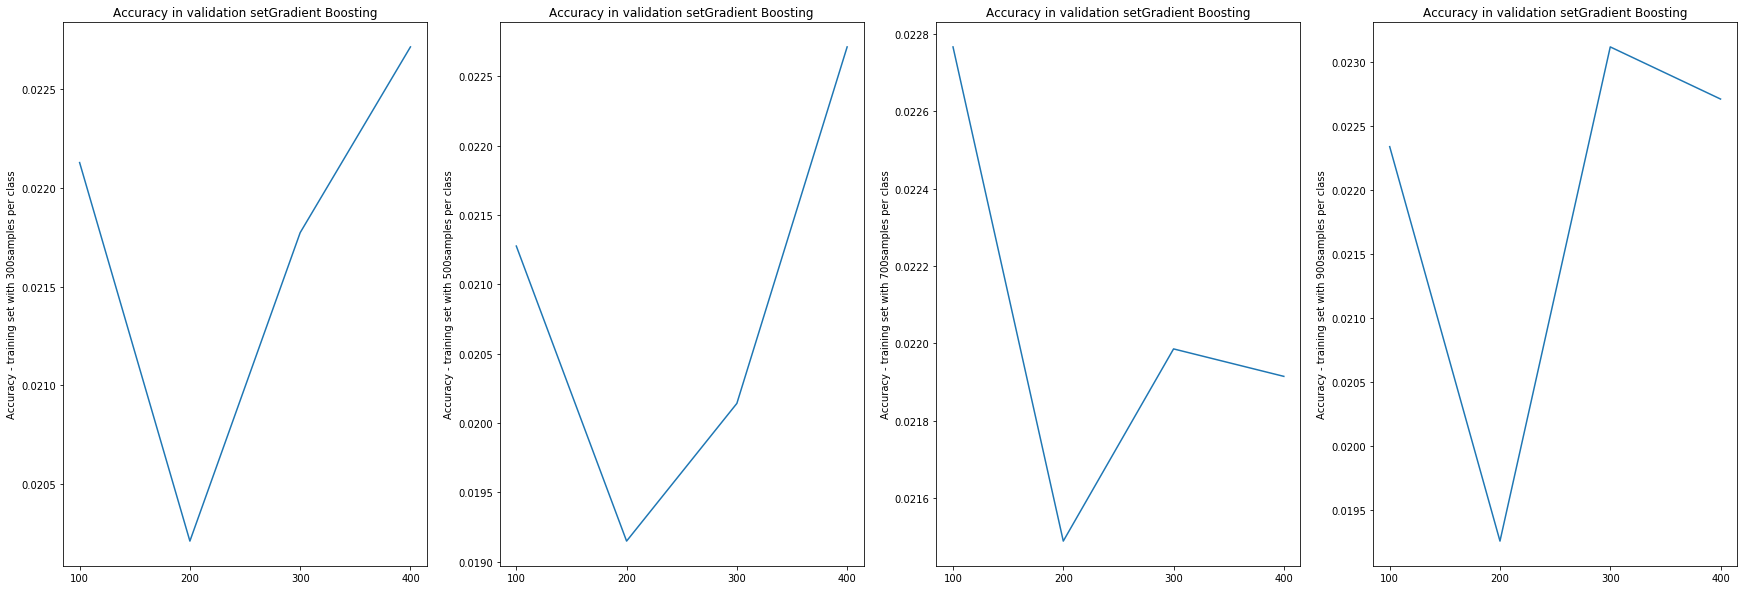

In [57]:
acc(clfs_names, scores_dig, n_trains, n_tests, "test")
acc(clfs_names, valid_errs, n_trains, n_valids, "validation")

In [ ]:
time_graph(clfs_names, times, n_trains)